## Introduction to Power Network Analysis with Pandapower
##### Xiangyue Wang, Thomas Morstyn

**Pandapower** is a popular open-sourced python package for power system modeling and optimization. Its name originates from the data analysis library, **pandas**, and the power flow solver library, **PYPOWER**. Pandapower combines the data structure of the former with solvers from the latter to:

- conduct static analysis of **three-phase distribution systems**, which are commonly found in Europe
- solve **AC and DC optimal power flow** problems
- conduct state estimation, static short-circuit simulation, and topological search.



As of Feburary, 2025, Pandapower **cannot** analyse distribution grids with unsymmetrical power lines design, such as the feeder design common in North America. It also cannot solved unbalanced power flow problems and conduct dynamic short-circuit simulation.

In this notebook, we will walk you through how to use pandapower for power flow optimization.

### Installation

We recommend running this tutorial in an Anaconda environment to avoid missing dependencies.

In [1]:
pip install pandapower

Note: you may need to restart the kernel to use updated packages.


The command above could result in an error if you are starting a new virtual environment without nothing else installed. In that case, use the **requirements.txt** file I included in the repository to install pandapower together with some necessary packages such as numpy and pandas.

In [2]:
# pip install requirements.txt

### First Example: Power Flow Modeling Review

Recall that electric systems almost everywhere involve sinusoidally varying AC voltages and currents. In other words,
$$ V(t) = V_{max} sin(\omega t+\theta_v)$$
$$ I(t) = I_{max} sin(\omega t+\theta_i)$$
where $\theta_v, \theta_i$ are phase angles, and $\omega$ is the angular frequency (50 Hz or 100 times of direction change per second for Europe). We are interested in steady state conditions at this fixed frequency since this is where normal power system operation takes place. **Specifically, we wish to find the voltage magnitude and voltage angle across the network given a set of generators and loads.**

In DC Power Flow Modeling, we are particularly concerned with the voltage angle difference between buses. For convenience, we set all voltage angles as the difference relative to a reference bus (called the **slack bus**, normally the largest generator for transmission network), whose angle is conventionally set to zero.

For example, if you have two voltage signals:

Bus 1 voltage: $V_1=V_{max}sin⁡(ωt)$

Bus 2 voltage: $V_2=V_{max}sin⁡(ωt−10\degree)$

The voltage angle of Bus 2 is -10° relative to Bus 1, or $V_2 = V_{max}\angle -10\degree$.
Note that voltage angles aren't physical angles of objects. Instead, they're determined indirectly using Phasor Measurement Units (PMUs), which measure precise time-stamped voltage and current waveforms at buses. Just as water moves from higher to lower pressure, electric power flows from higher voltage angle (sources) to lower voltage angle (loads). 

In DC Power Flow, we assume nodes have small voltage angle differences and small voltage drops (typically true for transmission) in order to linearize the sinusoidal AC voltage. For DC power flow, the power flow from bus k to j is

$$P_{kj} = \frac{1}{x_{kj}}(\theta_k - \theta_j) = B_{kj}(\theta_k - \theta_j)$$

where $x_{kj}$ is the line reactance and $B_{kj}$ is the line suceptance, or the kj-th entry of the admittance matrix.

Recall this example from the lecture:

![example_1.png](images/example_1.png)

where **pu** stands for **per unit** to simplify the calculation. Let's try to replicate this grid in pandapower. 
### How to Make a Grid in Pandapower
First, we import pandapower as **pp** and create an empty network using **pp.create_empty_network()**.

In [3]:
import pandapower as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandapower.plotting as plot

# Create an empty network
net1 = pp.create_empty_network()

Then, we create the buses using **create_bus**. Since the example is in a per unit system with no base unit specified, we will go ahead and assume the base voltage is 110 kV and the base active power is 100 MV.

In [4]:
# Set base values for the per unit system
base_kV = 110.0 # Base voltage in kV
base_MV = 100  # Base active power

#Create the buses
bus1 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 1")
bus2 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 2")
bus3 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 3")

#Show the bus table
net1.bus 

,name,vn_kv,type,zone,in_service,geo
0,Bus 1,110.0,b,None,True,None
1,Bus 2,110.0,b,None,True,None
2,Bus 3,110.0,b,None,True,None


Now, let's add the generators using **create_gen**. The diagram shows two generators. The first generator is connected to the slack bus, hence we set it as the slack generator with voltage magnitude (vm_pu) of 1 per unit. 

Even when the generator is a slack, we still need to give it an initial guess for p_mw, the active power. 0 is normally fine, because pandapower will calculate the actual value during the power flow. From the problem, we also know that generator 2 has p_mw of 1 per unit and reactive power (q_mvar) of 0.5 per unit.

In [5]:
#Create the generators
pp.create_gen(net1, bus=bus1, p_mw=0, vm_pu=1.0, slack=True, name="Generator 1")
pp.create_gen(net1, bus=bus2, p_mw=base_MV, q_mvar=0.5*base_MV, min_p_mw=0, max_p_mw=110, name="Generator 2")


1

Now, let's add the loads. We know that the load connected to bus 3 has active power of 2 per unit and reactive power of 0.5 per unit. 

In [6]:
#Create the loads
pp.create_load(net1, bus=bus3, p_mw=2*base_MV, q_mvar=0.5*base_MV, name="L3")

#Show the load table
net1.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,L3,2,200.0,50.0,0.0,0.0,NaN,1.0,True,wye


Lastly, let's add the lines. From the problem, we know that
$$z_{12} = 0.001 + j0.01 pu$$
$$z_{13} = 0.001 + j0.01 pu$$

meaning that each line has resistance (R) of 0.001 pu and reactance (X) of 0.01 pu. To add those lines, we need to convert per unit to Ohms by determining the base impedance:

$$Z_{base} = \frac{V^2_{base}}{S_{base}}$$

In [7]:
# Compute Base Impedance
z_base = base_kV**2 / base_MV  # in Ohms

# Line Impedances in Ohms
r_ohm = 0.001*z_base
x_ohm = 0.01*z_base

# Create the specific line used in Example 1
example1_line = {"r_ohm_per_km": r_ohm, "x_ohm_per_km": x_ohm, "c_nf_per_km": 10, "max_i_ka": 0.4, "type": "cs"}
pp.create_std_type(net1, name="example1_line", data=example1_line, element="line")
pp.available_std_types(net1, element="line")

length_km = 1  # nominal length

pp.create_line(net1, from_bus=bus1, to_bus=bus2, length_km=length_km, std_type="example1_line", name="line12")
pp.create_line(net1, from_bus=bus1, to_bus=bus3, length_km=length_km, std_type="example1_line", name="line13")

1

Now, let's have a look at the grid we created.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


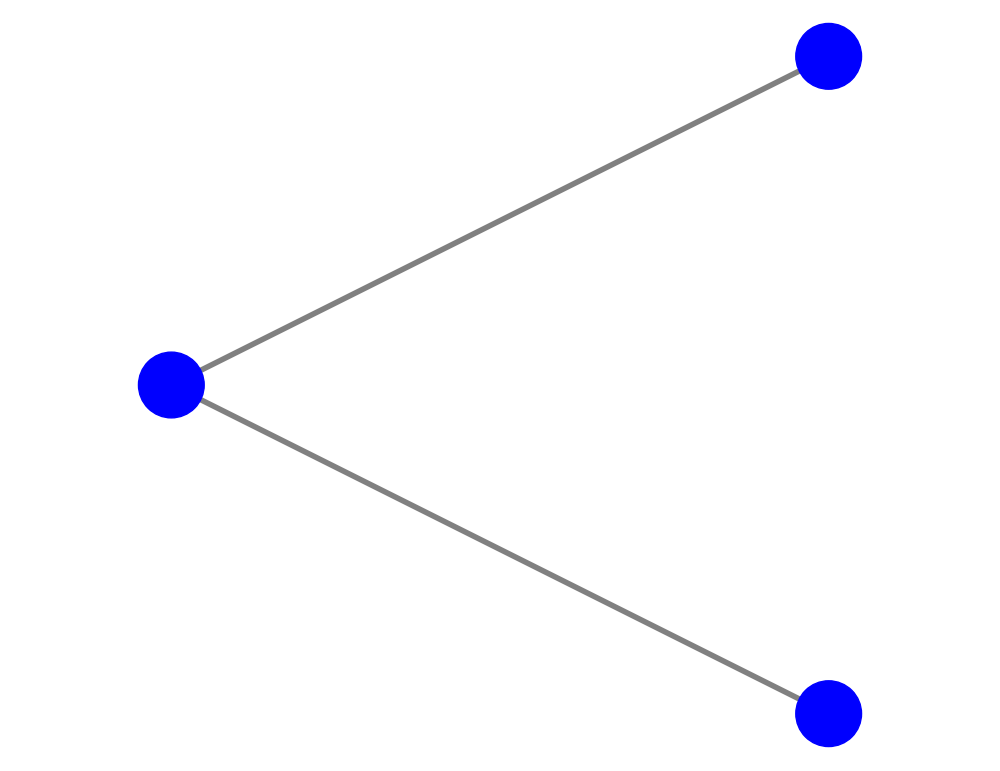

<Axes: >

In [8]:
#Show the Example 1 grid
plot.simple_plot(net1, show_plot=True, line_width=4, bus_size=5)

Let's go back to the question:

![example_1.png](images/example_1.png)

Recall how we would solve this problem analytically:

$$
\begin{bmatrix}
P_1\\
P_2\\
\vdots\\
P_N
\end{bmatrix}=\bold{B}\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}=
\begin{bmatrix}
B_{12} + B_{13} + \dots + B_{1N} & -B_{12}                 & \dots & -B_{1N}\\
-B_{21}                          & B_{21} + B_{22} + \dots + B_{2N} & \dots & -B_{2N}\\
\vdots                           & \vdots                           & \ddots & \vdots\\
-B_{N1}                          & -B_{N2}                          & \dots & B_{N1} + B_{N2} + \dots
\end{bmatrix}
\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}
$$

where $B_{ij} = \frac{1}{x_{ij}}$

Write the admittance matrix B for this problem and solve analytically:

Now, we will solve the DC power flow using pandapower's DC power flow solver.

In [9]:
#DC Power Flow
pp.rundcpp(net1)
print(net1.res_bus)


   vm_pu  va_degree   p_mw  q_mvar
0    1.0   0.000000 -100.0     NaN
1    1.0   0.572958 -100.0     NaN
2    1.0  -1.145916  200.0     NaN


We can also solve the same grid using the Balanced AC Power flow function.

In [10]:
# Run balanced AC power flow
pp.runpp(net1)
print(net1.res_bus)

      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -100.532105 -64.754756
1  1.000000   0.578405 -100.000000   9.509458
2  0.992758  -1.125501  200.000000  50.000000


### Second Example: Optimal Power Flow
Let's look at another example from the lecture. 
![example_2.png](images/example_2.png)

This time we are trying to optimize the power flow based on the cost of generation for each generator. 

Try creating an empty network and adding the generators and load yourself.


In [11]:
# Create an empty network
net2 = pp.create_empty_network()

# Set base values for the per unit system
base_kV = 110 # Base voltage in kV
base_MVA = 100 # Base apparent power

#Create the buses
b1 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 1")
b2 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 2")
b3 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 3")

#Create the generators 
gen1 = pp.create_gen(net2, bus=b1,  p_mw=0, min_p_mw=0, max_p_mw=300, vm_pu=1.0, slack=True, name="Generator 1")
gen2 = pp.create_gen(net2, bus=b2, p_mw=0, min_p_mw=0, max_p_mw=300, name="Generator 2")
gen3 = pp.create_gen(net2, bus=b3, p_mw=0, min_p_mw=0, max_p_mw=300, name="Generator 3")

# Add generator costs
pp.create_poly_cost(net2, element=gen1, et='gen', cp1_eur_per_mw=20)
pp.create_poly_cost(net2, element=gen2, et='gen', cp1_eur_per_mw=30)
pp.create_poly_cost(net2, element=gen3, et='gen', cp1_eur_per_mw=100)

#Create the loads
pp.create_load(net2, bus=b2, p_mw=3*base_MVA, q_mvar=0.5*base_MVA, name="L2")


0

Now, we need to add the lines with the specific powerflow limits. To add the limits, we need to convert the power limit into current limit. Recall that apparent power (S) in a three-phase system is given by
$$S = \sqrt{3}VI$$
$$I = \sqrt{3}VS$$
We will create a function **mw_to_ka** to do so.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


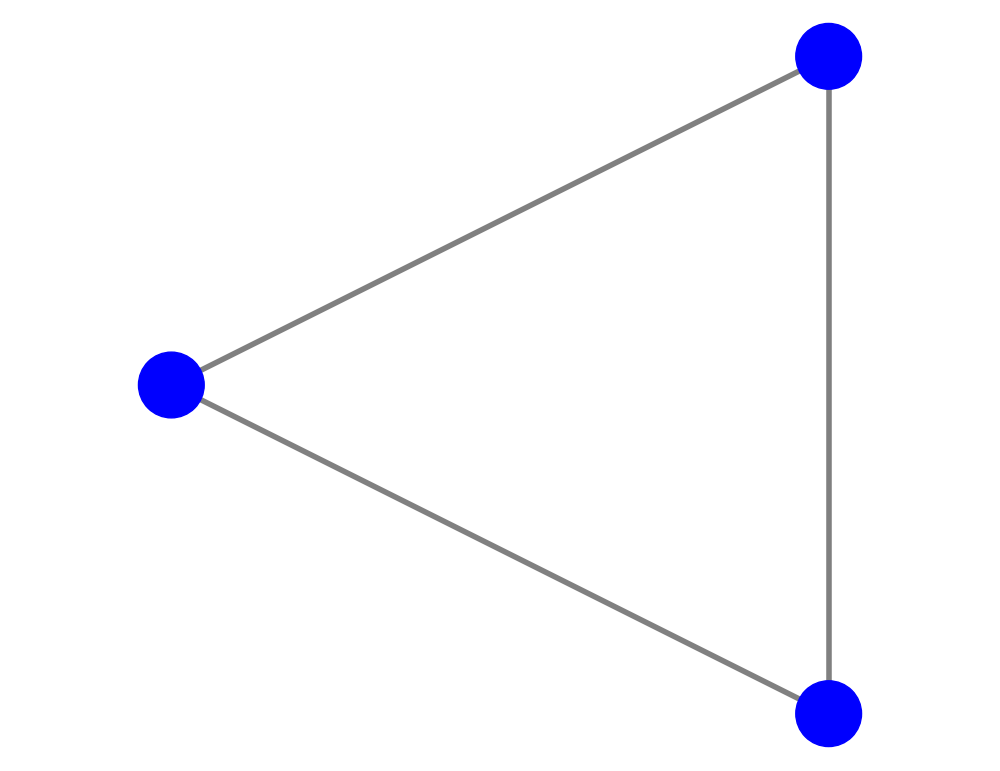

<Axes: >

In [12]:
# Compute Base Impedance
z_base = base_kV**2 / base_MVA  # in Ohms

# Line Impedances in Ohms
r_ohm = 0 # Since we don't have the info, let's assume we have negligible resistance
x_ohm = 0.5*z_base

length_km = 1  # nominal length

#Convert line flow limits from MW to kA (approx)
def mw_to_ka(p_mw, v_kv=base_kV):
    return p_mw / (v_kv * (3)**0.5)

# Add lines with limits
pp.create_line_from_parameters(net2, b1, b2, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line12")

pp.create_line_from_parameters(net2, b1, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line13")

pp.create_line_from_parameters(net2, b2, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(50), name="line23")

#Show the Example 2 grid
plot.simple_plot(net2, show_plot=True, plot_loads=True, plot_gens=True, line_width=4, bus_size=5)

In [13]:
# Run DC Optimal Power Flow
pp.rundcopp(net2)
print(net2.res_bus)


   vm_pu  va_degree          p_mw  q_mvar      lam_p  lam_q
0    1.0   0.000000 -3.000000e+02     NaN  27.364717    0.0
1    1.0 -57.295779  3.000000e+02     NaN  27.364717    0.0
2    1.0 -28.647890 -8.791375e-08     NaN  27.364717    0.0


In [14]:
# Run AC Optimal Power Flow
pp.runopp(net2)
print(net2.res_bus)

      vm_pu     va_degree        p_mw      q_mvar      lam_p         lam_q
0  0.967221  3.555237e-17 -299.999983 -144.180861  26.794023  2.711064e-20
1  1.065560 -6.772731e+01  299.999984 -201.217041  26.794023  3.506815e-20
2  0.967219 -3.572380e+01   -0.000001  -47.503016  26.794023  1.157226e-20


#### Solve Using PICOS

We can also try to solve the problem using **PICOS**, a python convex optimization package.

![example_2.png](images/example_2.png)

Our decision variables are the generator outputs, $P_{g1}, P_{g2}$, and $P_{g3}$ as well as the voltage angles $\theta_2, \theta_3$.


In [15]:
pip install picos

Note: you may need to restart the kernel to use updated packages.


In [18]:
import picos as pic

# Initialize the optimization problem.
prob = pic.Problem()

# Add decision variables: (name, size)
Pg1    = pic.RealVariable("Pg1") 
Pg2    = pic.RealVariable("Pg2")
Pg3    = pic.RealVariable("Pg3")
theta2 = pic.RealVariable("theta2")
theta3 = pic.RealVariable("theta3")

The objective function that we wish to minimize is the cost function:
$$C = 20P_{g1}+30P_{g2}+100P_{g3}$$

In [19]:
# Set objective function
prob.set_objective("min", 20*Pg1 + 30*Pg2 + 100*Pg3)

Lastly, the constraints are the power flow limit:
$$P_{kj} = \frac{1}{x_{kj}}(\theta_k - \theta_j)$$

which we have to convert to constraints on $P_{g1}, P_{g2}, P_{g3}$. Looking at the graph, we can notice that for bus 1:
$$P_{g1} = P_{12} + P_{13}$$
where 
$$P_{12} = 2(\theta_1 - \theta_2) = -2\theta_2$$
and 
$$P_{13} = 2(\theta_1 - \theta_3) = -2\theta_3$$

Hence
$$P_{g1} = -2\theta_2 - 2\theta_3$$

For bus 2, we don't expect the generator to transmit power through the lines since it is right next to the load.

For bus 3, since it is the most expensive, we can assume that it is used sparingly. In other words,
$$P_{g3} = P_{31} + P_{32} = P_{32} = 2(\theta_3 - \theta_2)$$

Lastly, we have to meet the demand.
$$P_{g1} + P_{g2} + P{g3} = 300$$


We will aslo add the line limits and generator limits (which, again, we assume since the problem doesn't provide the details).

In [20]:
# Power flow constraints:
prob.add_constraint(Pg1 + 2*theta2 + 2*theta3 == 0)  # Bus 1
prob.add_constraint(Pg3 - 2*theta3 + 2*theta2 == 0)  # Bus 2
prob.add_constraint(Pg1 + Pg2 + Pg3 == 300)  # Meet Demand

# Line limits
prob.add_constraint(theta2 >= -100)  # line 12
prob.add_constraint(theta2 <= 100)  # line 12
prob.add_constraint(theta3 >= -100)  # line 13
prob.add_constraint(theta3 <= 100)  # line 13
prob.add_constraint((theta2 - theta3)>= -25)  # line 23
prob.add_constraint((theta2 - theta3)<= 25)  # line 23

# Add generation bounds: 0 <= Pg_i <= 300
prob.add_constraint(Pg1 >= 0)
prob.add_constraint(Pg1 <= 300)
prob.add_constraint(Pg2 >= 0)
prob.add_constraint(Pg2 <= 300)
prob.add_constraint(Pg3 >= 0)
prob.add_constraint(Pg3 <= 300)

<1×1 Affine Constraint: Pg3 ≤ 300>

In [21]:
# Solve the optimization problem.
solution = prob.solve(verbose=True)

            PICOS 2.6.0            
Problem type: Linear Program.
Searching a solution strategy.
Solution strategy:
  1. ExtraOptions
  2. CVXOPTSolver
Applying ExtraOptions.
Building a CVXOPT problem instance.
Starting solution search.
-----------------------------------
 Python Convex Optimization Solver 
    via internal CONELP solver     
-----------------------------------


C:\Users\maxwa\AppData\Local\Temp\ipykernel_29208\1605568039.py:2: DeprecationWarning: Option 'verbose' is deprecated, use 'verbosity'.
  solution = prob.solve(verbose=True)


     pcost       dcost       gap    pres   dres   k/t
 0:  1.3819e+04 -1.4010e+04  3e+04  1e-01  3e-16  1e+00
 1:  6.2109e+03 -2.3105e+04  4e+04  1e-01  5e-15  4e+02
 2:  7.2054e+03  4.0887e+03  3e+03  1e-02  1e-14  1e+02
 3:  6.0104e+03  5.4884e+03  6e+02  2e-03  4e-15  3e+01
 4:  6.0001e+03  5.9947e+03  6e+00  2e-05  4e-16  3e-01
 5:  6.0000e+03  5.9999e+03  6e-02  2e-07  1e-15  3e-03
 6:  6.0000e+03  6.0000e+03  6e-04  2e-09  6e-16  3e-05
 7:  6.0000e+03  6.0000e+03  6e-06  2e-11  2e-16  3e-07
Optimal solution found.
------------[ CVXOPT ]-------------
Solver claims optimal solution for feasible problem.
Applying the solution.
Applied solution is primal feasible.
Search 5.0e-01s, solve 5.2e-01s, overhead 4%.
=============[ PICOS ]=============


In [27]:
# Print the results.
print("Pg1 =", Pg1)
print("Pg2 =", Pg2)
print("Pg3 =", Pg3)
print("theta2 =", theta2)
print("theta3 =", theta3)
print("\nCost = ", prob.value)

Pg1 = 299.99999998867855
Pg2 = 1.1121193739500243e-08
Pg3 = 2.0040467491579334e-10
theta2 = -74.99999999721973
theta3 = -74.99999999711953

Cost =  6000.000000127247


### Third Example: Great Britain Network

For our third example, let's look at a commonly used network available in pandapower.  The Great Britain (GB) Network represents the UK electricity transmission network. It consists of 2224 nodes, 3207 branches and 394 generators. We will import it from **pandapower.networks**, which contains a set of other useful grids. You can find out about them [here.](https://pandapower.readthedocs.io/en/v2.0.0/networks/power_system_test_cases.html#case-gb-network)

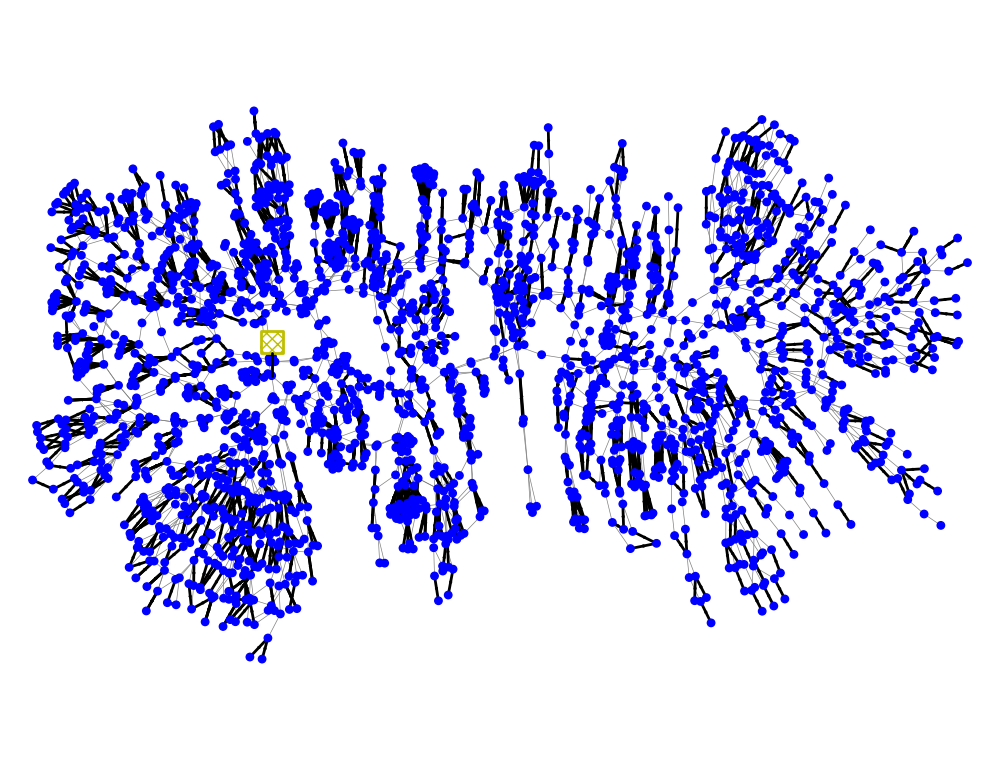

This pandapower network includes the following parameter tables:
   - bus (2224 elements)
   - load (446 elements)
   - sgen (37 elements)
   - gen (393 elements)
   - shunt (253 elements)
   - ext_grid (1 element)
   - line (1557 elements)
   - trafo (1650 elements)
   - poly_cost (394 elements)

In [28]:
import pandapower.networks as pn
net3 = pn.GBnetwork()
plot.simple_plot(net3, show_plot=True, trafo_size=0.02, line_width=0.5, bus_size=0.5)
net3


Solve both DC and AC Power flow on this grid. Observe the results describe which generators are used the most.

In [33]:
#DC Power Flow
pp.rundcpp(net3)
print(net3.res_bus)

      vm_pu  va_degree      p_mw    q_mvar
0      1.00  -0.078287    0.0000  0.000000
1      1.05   4.585871 -303.7966 -0.899733
2      1.05   4.629992 -304.3822 -8.167780
3      1.05   4.580016 -303.9515 -2.298052
4      1.00   2.404447    0.0000  0.000000
...     ...        ...       ...       ...
2219   1.00  68.787756   33.1300 -0.089511
2220   1.00  63.632587    0.0000  0.000000
2221   1.00  63.633114    0.0000  0.000000
2222   1.00  61.042266    9.7700  1.980000
2223   1.00  54.279564    0.0000  0.000000

[2224 rows x 4 columns]


In [34]:
#AC Power Flow
pp.runpp(net3)
print(net3.res_bus)

         vm_pu  va_degree      p_mw    q_mvar
0     1.049121  -1.492784    0.0000  0.000000
1     1.050000   2.744737 -303.7966 -0.899733
2     1.050000   2.782975 -304.3822 -8.167780
3     1.050000   2.738866 -303.9515 -2.298052
4     1.040346   0.293261    0.0000  0.000000
...        ...        ...       ...       ...
2219  1.057775  55.507208   33.1300 -0.089511
2220  1.000752  50.890542    0.0000  0.000000
2221  1.000762  50.890952    0.0000  0.000000
2222  1.038314  48.494137    9.7700  1.980000
2223  1.092362  42.246951    0.0000  0.000000

[2224 rows x 4 columns]
